 ### Building a regression model that tries to predict the estimated cumulative 6 month revenue from a new customer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import datetime as dt

In [2]:
order = pd.read_csv('brazilian_ecommerce/olist_orders_dataset.csv')
customer = pd.read_csv('brazilian_ecommerce/olist_customers_dataset.csv')
payment = pd.read_csv('brazilian_ecommerce/olist_order_payments_dataset.csv')


In [3]:
ord_paym = pd.merge (order, customer)
all_data = pd.merge (ord_paym, payment)

In [4]:
all_data.dropna (inplace = True)

In [5]:
all_data['order_purchase_timestamp'] = pd.to_datetime(all_data['order_purchase_timestamp'])
all_data['order_delivered_customer_date'] = pd.to_datetime(all_data['order_delivered_customer_date'])

In [6]:
all_data['year_order'] = all_data['order_purchase_timestamp'].dt.year

In [7]:
all_data['customer_unique_id'] = all_data['customer_unique_id'].astype(str)

In [8]:
all_data['month_order'] = all_data['order_purchase_timestamp'].dt.month

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100739 entries, 0 to 103885
Data columns (total 18 columns):
order_id                         100739 non-null object
customer_id                      100739 non-null object
order_status                     100739 non-null object
order_purchase_timestamp         100739 non-null datetime64[ns]
order_approved_at                100739 non-null object
order_delivered_carrier_date     100739 non-null object
order_delivered_customer_date    100739 non-null datetime64[ns]
order_estimated_delivery_date    100739 non-null object
customer_unique_id               100739 non-null object
customer_zip_code_prefix         100739 non-null int64
customer_city                    100739 non-null object
customer_state                   100739 non-null object
payment_sequential               100739 non-null int64
payment_type                     100739 non-null object
payment_installments             100739 non-null int64
payment_value                    100

In [10]:
all_data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'year_order', 'month_order'],
      dtype='object')

In [11]:
all_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,year_order,month_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12,2017,10
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00,2017,10
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59,2017,10
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,boleto,1,141.46,2018,7
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,credit_card,3,179.12,2018,8


In [12]:
all_data.reset_index

<bound method DataFrame.reset_index of                                 order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
103881  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
103882  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
103883  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
103884  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
103885  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status orde

In [13]:
all_data.loc[all_data['customer_unique_id']=='7c396fd4830fd04220f754e42b4e5bff']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,year_order,month_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12,2017,10
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00,2017,10
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59,2017,10
64908,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,44.11,2017,9


In [14]:
most_orders=all_data.loc[all_data['customer_unique_id']=='9a736b248f67d166d2fbb006bcb877c3']
most_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,year_order,month_order
29763,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,7,voucher,1,1.27,2017,7
29764,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,9,voucher,1,8.00,2017,7
29765,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,6,voucher,1,8.00,2017,7
29766,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,1,voucher,1,8.03,2017,7
29767,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,10,voucher,1,0.74,2017,7
29768,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,2,voucher,1,8.00,2017,7
29769,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,11,voucher,1,4.00,2017,7
29770,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,3,voucher,1,8.00,2017,7
29771,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,5,voucher,1,8.00,2017,7
29772,67d83bd36ec2c7fb557742fb58837659,7cfe09e5bc5e9f1fab1a57d8ddd8eaee,delivered,2017-07-27 12:50:46,2017-07-27 13:15:19,2017-07-31 20:29:16,2017-08-01 13:42:28,2017-08-16 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,4,voucher,1,8.00,2017,7


In [15]:
order_value = all_data.groupby('order_id')['payment_value'].sum().reset_index()
order_value.head()


,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [16]:
order_value.describe()

,payment_value
count,96460.000000
mean,159.855721
std,218.828474
min,9.590000
25%,61.880000
50%,105.280000
75%,176.330000
max,13664.080000


In [17]:
customer_value = all_data.groupby('customer_unique_id')['payment_value'].sum().reset_index()
customer_value.drop_duplicates(subset=None, keep='first', inplace=False)
customer_value.head()


,customer_unique_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [18]:
customer_value.describe()

,payment_value
count,93341.000000
mean,165.197318
std,226.329624
min,9.590000
25%,63.050000
50%,107.780000
75%,182.540000
max,13664.080000


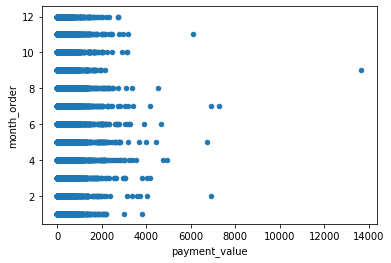

In [19]:
all_data.plot('payment_value', 'month_order', kind = 'scatter')

In [20]:
customer_count = all_data.groupby('customer_unique_id').count()[['order_id']].sum()
customer_count

order_id    100739
dtype: int64

/Users/cristinasandoval/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


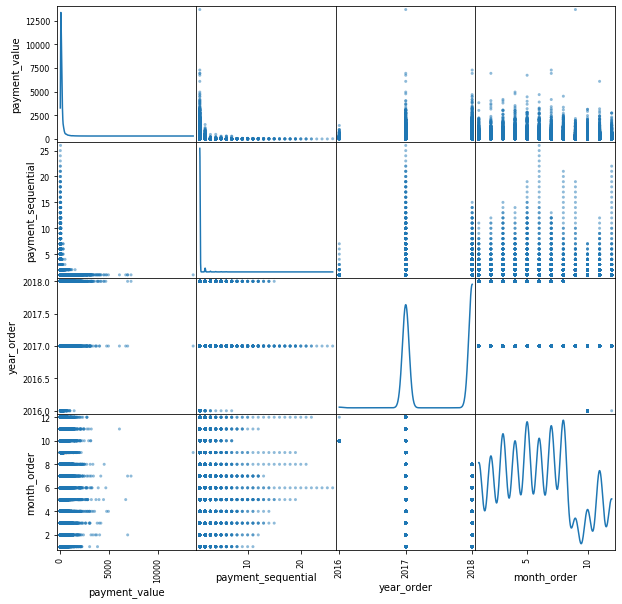

In [21]:
numeric_vars =['payment_value', 'payment_sequential', 'year_order', 'month_order', 'customer_unique_id']
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = scatter_matrix(all_data[numeric_vars], ax=ax, diagonal='kde')

In [23]:
linear_model = smf.ols(formula = 'payment_value ~ month_order + year_order + payment_type', data = all_data)
fitted_model = linear_model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          payment_value   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     234.1
Date:                Tue, 03 Dec 2019   Prob (F-statistic):          2.10e-249
Time:                        15:28:19   Log-Likelihood:            -6.8314e+05
No. Observations:              100739   AIC:                         1.366e+06
Df Residuals:                  100733   BIC:                         1.366e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -4669.6752   3233.890     -1.444      0.149    -1.1e+04    1668.709
payment_type[T.credit_card]    17.8362      1.727     10.327      0.000      14.451      21.221
payment_type[T.debit_card]     -4.7865      5.755     -0.832      0.406     -16.066       6.493
payment_type[T.voucher]       -81.7568      3.264    -25.045      0.000     -88.155     -75.359
month_order                     0.3492      0.250      1.397      0.162      -0.141       0.839
year_order                      2.3851      1.602      1.488      0.137      -0.756       5.526
==============================================================================
Omnibus:                   157749.939   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        292699099.716
Skew:                           9.578   Prob(JB):                         0.00
Kurtosis:                     266.373   Cond. No.                     9.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""